In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, algebra
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *
from pyiga import adaptive as adap
import itertools
import time

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

Populating the interactive namespace from numpy and matplotlib


In [2]:
geos = geometry.mp_disk()

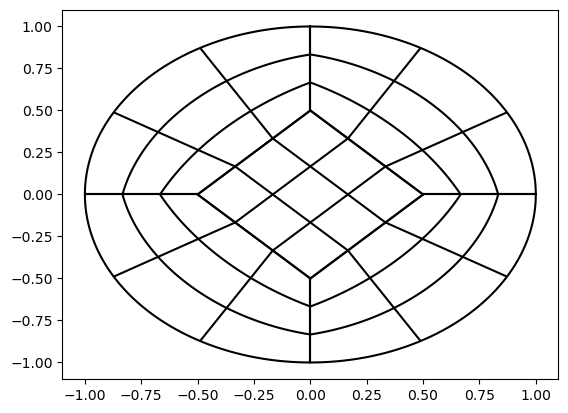

In [3]:
for geo in geos:
    vis.plot_geo(geo, grid=4)

In [12]:
coeffs=geometry.bspline_annuseg(phi=pi/4).coeffs

In [22]:
coeffs[:,0,:][:,0]

array([1.000, 0.854, 0.707])

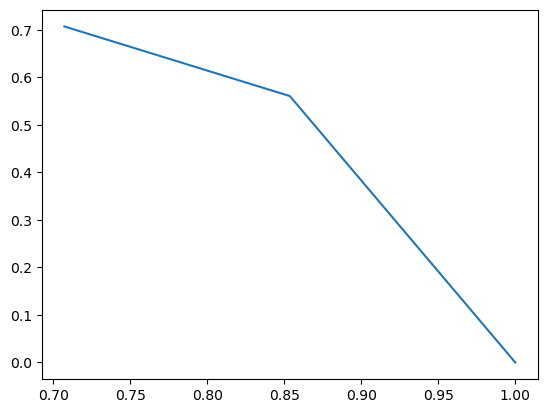

In [24]:
plt.plot(coeffs[:,0,:][:,0],coeffs[:,0,:][:,1])

In [28]:
def doerfler_marking(errors, theta=0.9):
    """Given a list of errors, return a minimal list of indices such that the indexed
    errors have norm of at least theta * norm(errors)."""
    ix = np.argsort(errors)
    total = np.linalg.norm(errors)
    running = []
    marked = []
    for i in reversed(range(len(ix))):
        running.append(errors[ix[i]])
        marked.append(ix[i])
        print(np.linalg.norm(running) >= theta * total)
        if (np.linalg.norm(running) >= theta * total) and ((errors[ix[i]]-errors[ix[min(i+1,0)]])/errors[ix[i]]>1e-4):
            break
    return marked

In [29]:
errors=[0.95,0.01,0.01,0.01,0.01,0.01]

In [39]:
doerfler_marking(errors,0.99999)

False
False
False
False
False
True


[0, 5, 4, 3, 2, 1]

In [195]:
np.linalg.matrix_rank(LS.A.A)

23

In [196]:
u=scipy.linalg.null_space(LS.A.A)

In [199]:
u_=[LS.complete(u[:,i]) for i in range(u.shape[1])]

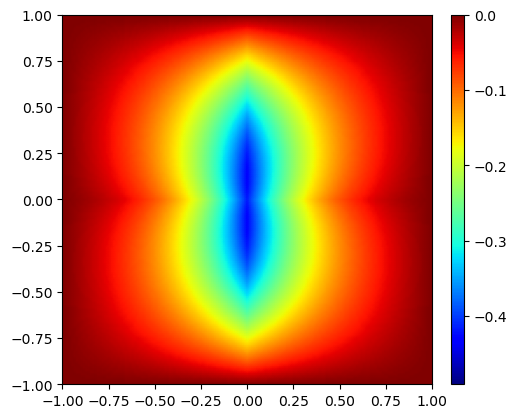

In [201]:
MP.plot(u_[1])

In [165]:
A@u_

array([0.000, 0.000, -0.000, -0.000, -0.000, 0.000, 0.000, -0.000, -0.000, -0.000, -0.000, 0.000, 0.000, 0.000, -0.000, 0.000, -0.000, 0.000, -0.000, -0.000, 0.000, 0.000, -0.000, 0.000, -0.000])

In [107]:
A=assemble.assemble("tr(hess(u)) * tr(hess(v)) * dx", kvs=kvs[0], bfuns=[('u',1), ('v',1)], geo=geos[0])
Mh=assemble.assemble("u * v * dx",bfuns=[('u',1), ('v',1)],kvs=kvs[0],geo=geos[0])
U = assemble.assemble("f * v * dx",bfuns=[('v',1)],kvs=kvs[0],geo=geos[0],f=lambda x,y: y).ravel()
#Ak = [assemble.assemble('tr(hess(u)) * tr(hess(v)) * dx', kvs, bfuns=[('u',1), ('v',1)], geo=g) for g in geos]
bcs=assemble.compute_dirichlet_bcs(geo=geos[0], bdconds=[([(0,0)],0.),([(0,1)],0.),([(1,0)],0.),([(1,1)],0.)], kvs=kvs[0])

In [108]:
LS = assemble.RestrictedLinearSystem(A, U, bcs)

In [109]:
u_ = scipy.sparse.linalg.spsolve(Mh,U)

In [110]:
LS.A.A.shape

(121, 121)

In [113]:
np.linalg.matrix_rank(LS.A.A)

121

In [ ]:
kvsx=(kvs[0],kvs[1].deriv(deriv=1)

In [17]:
MP=assemble.Multipatch(M,automatch=True)

Basis setup took 0.0048313140869140625 seconds


In [18]:
u_=MP.L2projection(lambda x,y: (x-0.5)**2 + (y-0.5)**2)

In [19]:
u = bspline.BSplineFunc(kvs[0],u_)

In [10]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]

kvs=[(bspline.make_knots(1,0.0,1.0,xN),bspline.make_knots(1,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      geometry.Quad(np.array([[0.,2.,1.,2.],
                              [1.,1.,2.,2.]])),
      geometry.Quad(np.array([[2.,3.,2.,3.5],
                              [1.,1.,2.,2.5]])),
      geometry.Quad(np.array([[2.,3.,3.,3.5],
                              [1.,0.,1.,0.5]])),
      geometry.Quad(np.array([[2.,2.5,2.,3.],
                              [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
M=topology.PatchMesh(patches)
M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

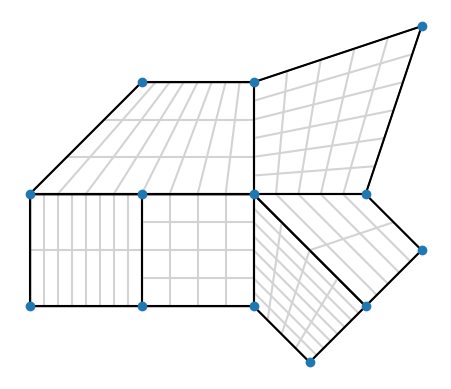

In [18]:
M.draw(knots=1, patch_idx=0, nodes=1, axis='off')
axis('scaled');

In [2]:
def drawSkeleton(MP):
    for (p,b,_),(_,_,_),_ in MP.intfs:
        ax,sd=assemble.int_to_bdspec(b)
        geo=MP.mesh.geos()[p]
        kvs=MP.mesh.kvs()[p]
        grid=np.linspace(geo.support[(ax+1)%2][0], geo.support[(ax+1)%2][1],kvs[(ax+1)%2].numdofs)
        if (p,b) == (4,1) or (p,b)==(5,3): grid=grid[1:-1]
        if ax==0:
            Z = geo.eval(grid,np.array([geo.support[0][sd]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd]]),grid)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs()[p], MP.mesh.geos()[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)